In [1]:
import torch
import torch.nn as nn
import os
import torchvision
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd 
import albumentations as A
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations.pytorch import ToTensorV2
import tqdm.notebook as tq

In [2]:
dataset = pd.read_csv('/content/train-scene classification/train.csv')
dataset.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [3]:
root_dir = '/content/train-scene classification/train/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2


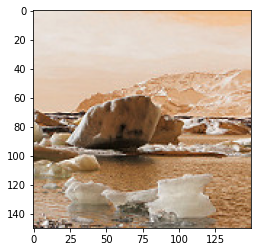

In [4]:
  random = np.random.randint(100)  
  img_example = cv2.imread(root_dir + dataset.iloc[random,0])
  print(dataset.iloc[random,1])
  plt.imshow(img_example)

In [5]:
train, val = train_test_split(dataset, test_size = 0.2, stratify = dataset.label.values)

In [6]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x.view(x.shape[0],-1))

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [7]:
class ImageDataset(Dataset):
  def __init__(self, dataset, root_dir, transform = None):
    self.dataset = dataset 
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return(len(self.dataset))
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_path = os.path.join(self.root_dir, self.dataset.iloc[idx, 0])
    image = cv2.imread(img_path)
    label = torch.tensor(self.dataset.iloc[idx,1])

    if self.transform:
      res = self.transform(image=image)
      image = res['image']

    return (image, label)

In [8]:
image_size = 224
batch_size = 64 
learning_rate = 0.0001
image_channels = 3
num_epochs = 10
num_classes = 6

In [9]:
transforms = A.Compose(
        [
            A.Resize(height=image_size, width=image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )



train_dataset = ImageDataset(train,root_dir,transform=transforms) 

val_dataset = ImageDataset(val, root_dir,
                             transform = transforms)

In [10]:
def ResNet50( num_classes, image_channels=3):
  return ResNet(block, [3,4,6,3], image_channels, num_classes)

#ResNet101 = ResNet(block, [3,4,23,3],  image_channels=3, num_classes=num_classes)

#ResNet152 = ResNet(block, [3,4,36,3],  image_channels=3, num_classes=num_classes)

model = ResNet50(num_classes).to(device)

In [11]:
train_loader = DataLoader(dataset= train_dataset, batch_size=batch_size, shuffle = True)
val_loader =  DataLoader(dataset= val_dataset, batch_size=batch_size, shuffle = True)
optimizer = optim.Adam(model.parameters(),lr= learning_rate)
criterion = nn.CrossEntropyLoss()

In [12]:
train_loss_list = []
valid_loss_list = []
for epoch in range(1,num_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    bar = tq.tqdm(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})

    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq.tqdm(val_loader, postfix={"valid_loss":0.0})
        for data, target in bar:
            data =  data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item()})
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    

    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))


Epoch: 1  Training Loss: 1.022899  Validation Loss: 0.933219



Epoch: 2  Training Loss: 0.725114  Validation Loss: 0.596043



Epoch: 3  Training Loss: 0.590602  Validation Loss: 0.545110



Epoch: 4  Training Loss: 0.523364  Validation Loss: 0.538752



Epoch: 5  Training Loss: 0.475655  Validation Loss: 0.484441



Epoch: 6  Training Loss: 0.442257  Validation Loss: 0.442347



Epoch: 7  Training Loss: 0.414188  Validation Loss: 0.728211



Epoch: 8  Training Loss: 0.372845  Validation Loss: 0.516359



Epoch: 9  Training Loss: 0.351350  Validation Loss: 0.506421



Epoch: 10  Training Loss: 0.323126  Validation Loss: 0.498141


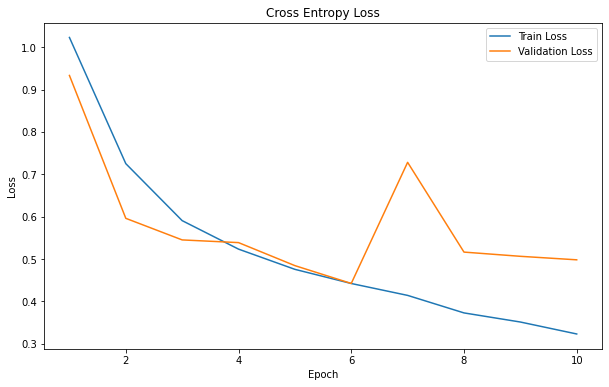

In [13]:
plt.figure(figsize=(10,6))
plt.plot([i for i in range(1,num_epochs+1)], train_loss_list, label = "Train Loss")
plt.plot([i for i in range(1,num_epochs+1)], valid_loss_list, label = "Validation Loss")
plt.title("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()